# Process of Benchmarking data

In [1]:
from functions import averageOfFidelity, stdOfFidelity, decay_param, decay_func
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
from scipy.optimize import curve_fit

In [3]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

In [4]:
n_qubit = 1
noise_model = 'depolarising_noise'
number_sequences = 50
path = os.path.join( os.getcwd(), 'output_storage', noise_model )

In [5]:
avg_fdlty_dict = {}
err_fdlty_dict = {}
ordered_layers_dict = {}

In [6]:
def capture_bench_arrays(path, version_name, number_sequences):
#     path = os.path.join( os.getcwd(), 'output_storage', noise_model, folder_name )

    ordered_layers = np.load(os.path.join(path, 'layers_indices.npy'))

    avg_fdlty_arr = np.load(os.path.join(path, 'rb_'+ version_name + '_' + str(number_sequences) +'_avg_layers.npy'))
    err_fdlty_arr = np.load(os.path.join(path, 'rb_'+ version_name + '_' + str(number_sequences) +'_err_layers.npy'))
    return ordered_layers, avg_fdlty_arr, err_fdlty_arr


In [7]:
def extrapolate_decay_func(ordered_layers_arr, avg_fdlty_arr, err_fdlty_arr):
    try:
        popt, pcov = curve_fit(decay_func, ordered_layers_arr, avg_fdlty_arr)
    except:
        popt, pcov = curve_fit(decay_func, ordered_layers_arr, avg_fdlty_arr, bounds=([0,0,-10], [1., 10., 0.]))
    return popt, pcov

def plot_decay(avg_fdlty_arr, popt, pcov, title:str):
    fig = plt.figure()
    ax = fig.add_subplot()

    ax.scatter(ordered_layers, avg_fdlty_arr)
    ax.plot(between_layers, decay_func(between_layers, *popt), label = r'${1}*{0}^m+{2}$'.format(*np.round(popt,2)))


    plt.xlabel('Depth', fontsize=18)
    plt.ylabel('Average of Fidelity', fontsize=16)
    plt.title('RB' + title)

    plt.legend()
    fig.savefig('RB_' + title + '.png')

In [8]:
temp_path = os.path.join('output_storage', noise_model )
for version in ['standard', 'native', 'native_conditional']:
    avg_fdlty_dict[version] = {}
    err_fdlty_dict[version] = {}
    ordered_layers_dict[version] = {}
    for epsilon in [0.01, 0.001,0.002,0.004,0.006,0.008]:
        path = os.path.join(temp_path, 'epsilon' + str(epsilon))
        
        try:
            ordered_layers, avg_fdlty_arr, err_fdlty_arr = capture_bench_arrays(path, version, number_sequences)
            avg_fdlty_dict[version].update({epsilon:avg_fdlty_arr})
            err_fdlty_dict[version].update({epsilon:err_fdlty_arr})
            ordered_layers_dict[version].update({epsilon:ordered_layers})
        except:
            pass

In [9]:
avg_fdlty_dict

{'standard': {0.01: array([0.93175, 0.8703 , 0.8129 , 0.75285, 0.698  , 0.6578 , 0.6177 ,
         0.57815, 0.5454 , 0.51065]),
  0.001: array([0.99235, 0.98655, 0.9774 , 0.9701 , 0.9652 , 0.9538 , 0.94805,
         0.93915, 0.933  , 0.92705]),
  0.002: array([0.9861 , 0.9727 , 0.9568 , 0.9434 , 0.9291 , 0.9165 , 0.8969 ,
         0.884  , 0.8726 , 0.85825]),
  0.004: array([0.97095, 0.9428 , 0.9139 , 0.89015, 0.86455, 0.82925, 0.81215,
         0.78865, 0.76725, 0.74185]),
  0.006: array([0.95825, 0.918  , 0.87605, 0.8397 , 0.8011 , 0.76335, 0.73875,
         0.6983 , 0.6763 , 0.64775]),
  0.008: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])},
 'native': {0.01: array([0.93545, 0.87265, 0.81105, 0.76565, 0.71055, 0.6609 , 0.62045,
         0.5875 , 0.5561 , 0.52385])},
 'native_conditional': {0.01: array([0.8328 , 0.72425, 0.65385, 0.60595, 0.57105, 0.5469 , 0.52835,
         0.52275, 0.51775, 0.5073 ]),
  0.008: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}}

In [33]:
def plot_bench_arrays(axes, version, epsilon):
    popt, pcov = extrapolate_decay_func( ordered_layers_dict[version][epsilon],
                                        avg_fdlty_dict[version][epsilon], err_fdlty_dict[version][epsilon])
    r = decay_param(popt[0], n_qubit)
    between_layers = np.arange(ordered_layers_dict[version][epsilon].min(),ordered_layers_dict[version][epsilon].max(),1).astype('int')
    
    axes.errorbar(ordered_layers_dict[version][epsilon], avg_fdlty_dict[version][epsilon],
                yerr = err_fdlty_dict[version][epsilon],
                fmt = 'o', color = 'k')
    axes.plot(between_layers, decay_func(between_layers, *popt),
              label = version + r': ${1}*{0}^m+{2}$'.format(*np.round(popt,5)))
    return


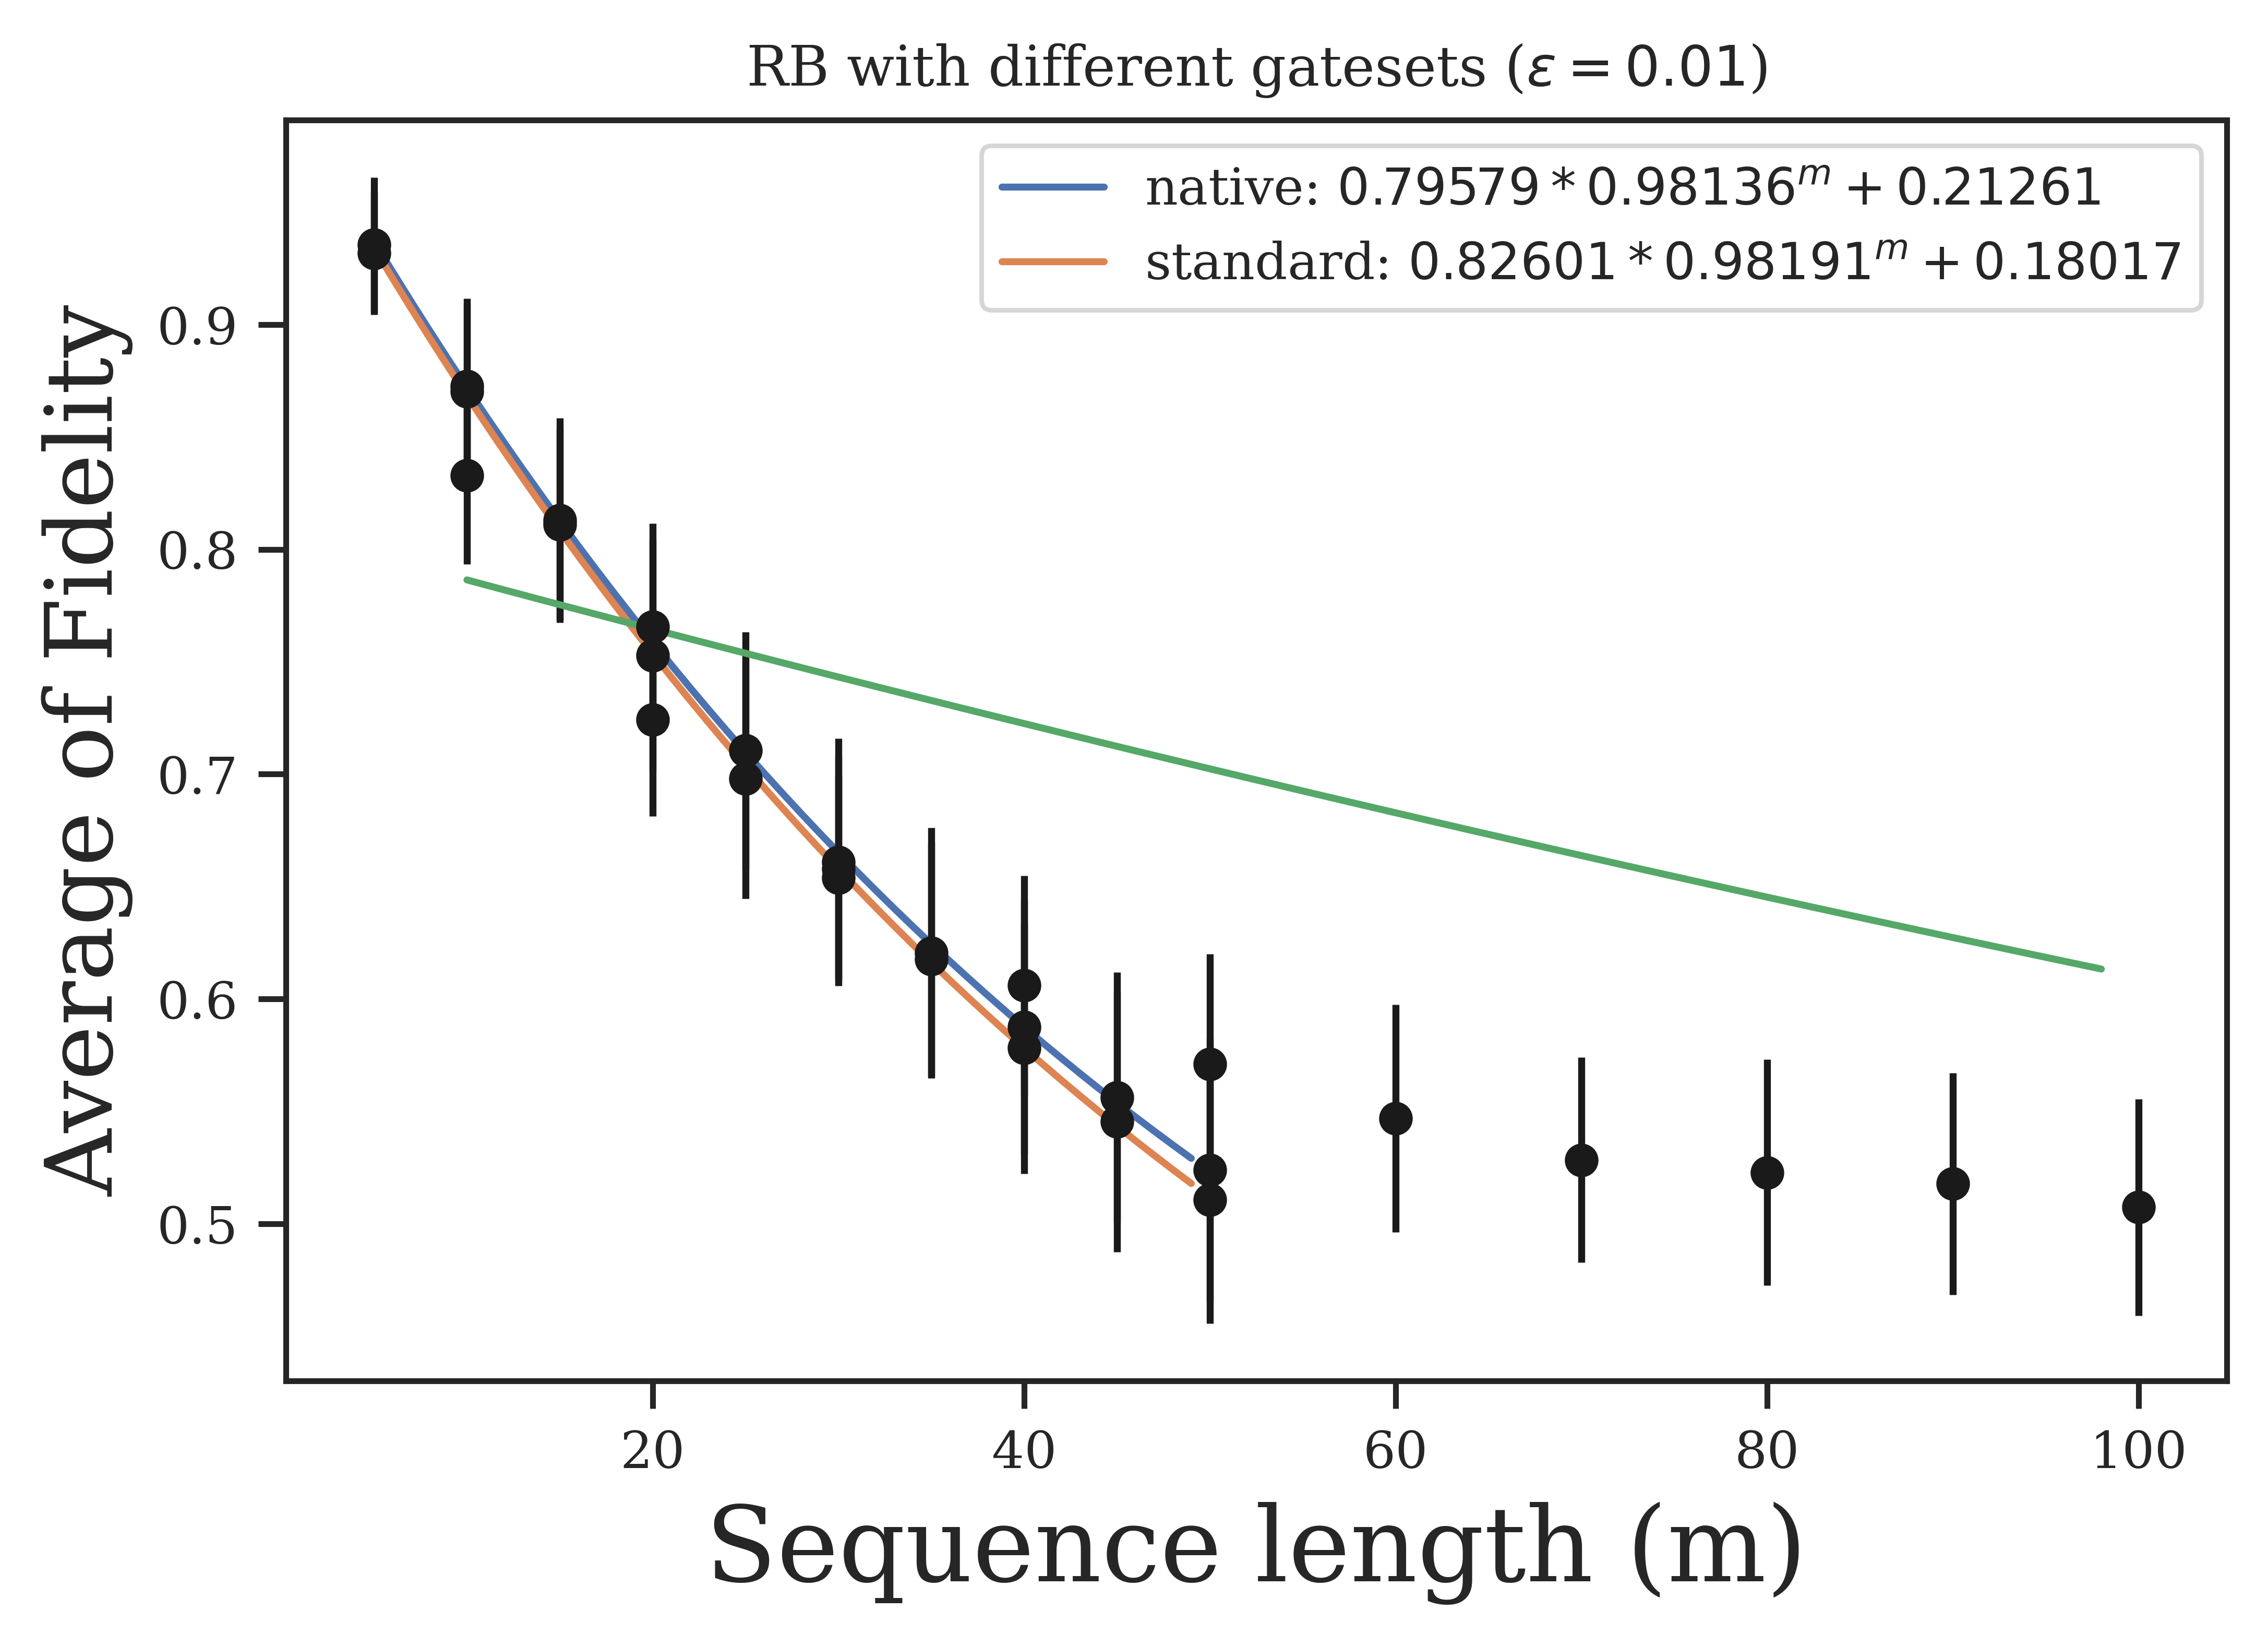

In [35]:
fig = plt.figure(dpi = 800)
ax = fig.add_subplot()

epsilon = 0.01

version = 'native'
plot_bench_arrays(ax, version, epsilon)

version = 'standard'
plot_bench_arrays(ax, version, epsilon)

version = 'native_conditional'
popt, pcov = extrapolate_decay_func( ordered_layers_dict[version][epsilon] * 2,
                                    avg_fdlty_dict[version][epsilon], err_fdlty_dict[version][epsilon])
r = decay_param(popt[0], n_qubit)

ax.errorbar(ordered_layers_dict[version][epsilon] * 2, avg_fdlty_dict[version][epsilon],
            yerr = err_fdlty_dict[version][epsilon],
            fmt='o', color = 'k')

between_layers = np.arange(ordered_layers_dict[version][epsilon].min(),ordered_layers_dict[version][epsilon].max(),1).astype('int')
ax.plot(between_layers*2, decay_func(between_layers, *popt))

ax.set_xlabel('Sequence length (m)', fontsize=18)
ax.set_ylabel('Average of Fidelity', fontsize=16)
ax.set_title(r'RB with different gatesets ($\epsilon = {}$)'.format(epsilon))

plt.legend()

# fig.savefig(os.path.join(path, 'RB_std_ntv_comparison_'+folder_name +'.png'))


## epsilon-approximate t-design vs. exact one

In [ ]:
epsilon = 0.001

popt_std, pcov_std = curve_fit(decay_func, ordered_layers_dict[epsilon], avg_std_fdlty_dict[epsilon],
                               bounds=([0,0,-10], [1., 10., 0.]))
r_std = decay_param(popt_std[0], n_qubit)

popt_rng, pcov_rng = curve_fit(decay_func, ordered_layers_dict[epsilon], avg_rng_fdlty_dict[epsilon]
                               , bounds=([0,0,-10], [1., 10., 0.]))
r_rng = decay_param(popt_rng[0], n_qubit)

fig = plt.figure(dpi = 1000)
ax = fig.add_subplot()

# plt.loglog()

ax.errorbar(ordered_layers_dict[epsilon], avg_rng_fdlty_dict[epsilon], yerr = err_rng_fdlty_dict[epsilon],
            fmt='x',color = 'r', alpha = 0.6,
            label = 'Native gateset (r = {})'.format(np.round(r_rng,6)))
ax.errorbar(ordered_layers_dict[epsilon], avg_std_fdlty_dict[epsilon], yerr = err_std_fdlty_dict[epsilon],
            fmt = '^', color = 'm', alpha = 0.6,
            label = 'Clifford gateset (r = {})'.format(np.round(r_std,6)))

plt.xlabel('Sequence length (m)', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)
plt.title(r'RB with different gatesets ($\epsilon = {}$)'.format(epsilon))

plt.legend()

# fig.savefig(os.path.join(path, 'RB_std_ntv_comparison_'+folder_name +'.png'))


## Two depolarising noises at hand

In [ ]:
def root_sum_squared(array_one, array_two):
    return np.sqrt( array_one**2 + array_two**2 )

In [ ]:
fig = plt.figure(dpi = 1000)
# fig = plt.figure()
ax = fig.add_subplot()

for epsilon in [0.001,0.002,0.004,0.006,0.008]:

    # plt.loglog()

    ax.errorbar(ordered_layers_dict[epsilon], avg_rng_fdlty_dict[epsilon] - avg_std_fdlty_dict[epsilon],
                yerr = root_sum_squared(err_rng_fdlty_dict[epsilon],err_std_fdlty_dict[epsilon]),
                alpha = 0.6, fmt='x',
                label = '{}'.format(epsilon))


plt.xlabel('Sequence length (m)', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)
plt.title('Average fidelity difference for depolarising noise'.format(epsilon))

plt.legend()

# fig.savefig(os.path.join(path, 'RB_std_ntv_comparison_'+folder_name +'.png'))


## Convex combination of two depolarising noise models

In [ ]:
# fig = plt.figure(dpi = 1000)
# # fig = plt.figure()
# ax = fig.add_subplot()

# for epsilon in [0.001,0.002,0.004,0.006,0.008]:
#     delta = (epsilon - 0.001)/0.009
#     # plt.loglog()

#     ax.errorbar(ordered_layers_dict[epsilon], avg_rng_fdlty_dict[epsilon] - avg_std_fdlty_dict[epsilon],
#                 yerr = root_sum_squared(err_rng_fdlty_dict[epsilon],err_std_fdlty_dict[epsilon]),
#                 alpha = 0.6, fmt='x',
#                 label = r'$\delta$ = {}'.format(np.round(delta,2)))


# plt.xlabel('Sequence length (m)', fontsize=18)
# plt.ylabel('Average of Fidelity', fontsize=16)
# plt.title(r'Average fidelity difference for $\Lambda = (1-\delta) \Lambda_C + \delta \Lambda_N$'.format(epsilon))

# plt.legend()

# fig.savefig(os.path.join(path, 'RB_combination_two_dep_noises.png'))


## Underconstruction

In [ ]:
# fig = plt.figure(dpi = 1000)
# # fig = plt.figure()
# ax = fig.add_subplot()

# for epsilon in [0.001,0.002,0.004,0.006,0.008]:
#     delta = (epsilon - 0.001)/0.009
#     # plt.loglog()

#     ax.errorbar(ordered_layers_dict[epsilon], avg_rng_fdlty_dict[epsilon] - avg_std_fdlty_dict[epsilon],
#                 yerr = root_sum_squared(err_rng_fdlty_dict[epsilon],err_std_fdlty_dict[epsilon]),
#                 alpha = 0.6, fmt='x',
#                 label = r'$\delta$ = {}'.format(np.round(delta,2)))


# plt.xlabel('Sequence length (m)', fontsize=18)
# plt.ylabel('Average of Fidelity', fontsize=16)
# plt.title(r'Average fidelity difference for $\Lambda = (1-\delta) \Lambda_C + \delta \Lambda_N$'.format(epsilon))

# plt.legend()

# fig.savefig(os.path.join(path, 'RB_combination_two_dep_noises.png'))


In [ ]:
# avg_points = {x:np.array([ordered_layers_dict[x], avg_rng_fdlty_dict[x]]).T for x in avg_rng_fdlty_dict}

In [ ]:
# plt.scatter(avg_points[0.001])

In [ ]:
# avg_points[0.001]